<a href="https://colab.research.google.com/github/reonho/nba_shotlogs/blob/master/NBAnalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basketball Analytics** :  An Econometric Analysis of NBA 2014-15


In the movie **Moneyball**, Yale economist Peter Brand uses econometrics to build the best baseball team for as little money as possible. In this project we try to recreate something similar for the NBA - by finding out quantitatively what kinds of plays, players or game conditions make or break baskets.

We examine NBA's shooting records from 2014 - 2015 together with game conditions and player stats from prior seasons. 

Our target is to identify optimal conditions for successful shots. That is, we want to know how game conditions (defender distance, shooter distance from rim etc.) affect the probability of making a basket.


 The data was obtained from the following kaggle links.
 
 Shot logs:  https://www.kaggle.com/dansbecker/nba-shot-logs 
 
 Player stats: https://www.kaggle.com/justinas/nba-players-data




In [0]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Data Exploration

### Shot Log Data


In [0]:
url = "https://raw.githubusercontent.com/reonho/nba_shotlogs/master/shot_logs.csv"
sdta = pd.read_csv(url)

In [36]:
sdta.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,1.9,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,0.8,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,2.7,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,1.9,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


The objective is to analyse if a shot is made or missed. A good place to start would be to visualise the outcomes of all the shots in the dataset. It is also useful to observe the difference between 2 and 3 pointers.  


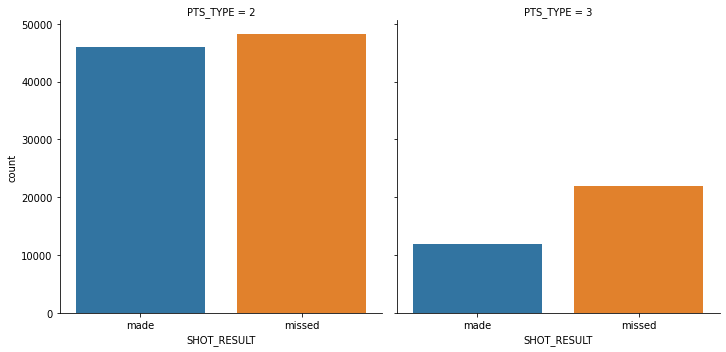

In [37]:
ax = sns.catplot("SHOT_RESULT", col = "PTS_TYPE", data=sdta,kind="count", height=5)

In [38]:
print("A Total of" , sum((sdta.SHOT_RESULT == "made") & (sdta.PTS_TYPE == 3)), "three point shots were made. This works out to", "{:.2f}%".format(sum((sdta.SHOT_RESULT == "made") & (sdta.PTS_TYPE == 3))/sum(sdta.PTS_TYPE == 3)*100) , "basket rate")
print("A Total of" , sum((sdta.SHOT_RESULT == "made") & (sdta.PTS_TYPE == 2)), "two point shots were made. This works out to", "{:.2f}%".format(sum((sdta.SHOT_RESULT == "made") & (sdta.PTS_TYPE == 2))/sum(sdta.PTS_TYPE == 2)*100) , "basket rate")

A Total of 11915 three point shots were made. This works out to 35.15% basket rate
A Total of 45990 two point shots were made. This works out to 48.84% basket rate


In both cases, a typical player is statistically more likley to miss a basket than to make one. For 2 point shots, NBA Players make a basket slightly below half the time, but for 3 point shots this is about a third of the time.

We continue to do some exploratory analysis by viewing the summary statistics. Of interest are the statistics of the following features:

1. SHOT_NUMBER
2. PERIOD
3. SHOT_CLOCK
4. DRIBBLES
5. TOUCH_TIME
6. SHOT_DIST
7. CLOSE_DEF_DIST

These columns represent meaningful continuous/numerical data, and their distributions could provide some insights for us.



In [39]:
sdta_num = sdta[["SHOT_NUMBER", 
      "PERIOD",
      "SHOT_CLOCK",
      "DRIBBLES", 
      "TOUCH_TIME",
      "SHOT_DIST",
      "CLOSE_DEF_DIST",]]
      
sdta_num.describe()

,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST
count,128069.000000,128069.000000,122502.000000,128069.000000,128069.000000,128069.000000,128069.000000
mean,6.506899,2.469427,12.453344,2.023355,2.765901,13.571504,4.123015
std,4.713260,1.139919,5.763265,3.477760,3.043682,8.888964,2.756446
min,1.000000,1.000000,0.000000,0.000000,-163.600000,0.000000,0.000000
25%,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.300000
50%,5.000000,2.000000,12.300000,1.000000,1.600000,13.700000,3.700000
75%,9.000000,3.000000,16.675000,2.000000,3.700000,22.500000,5.300000
max,38.000000,7.000000,24.000000,32.000000,24.900000,47.200000,53.200000


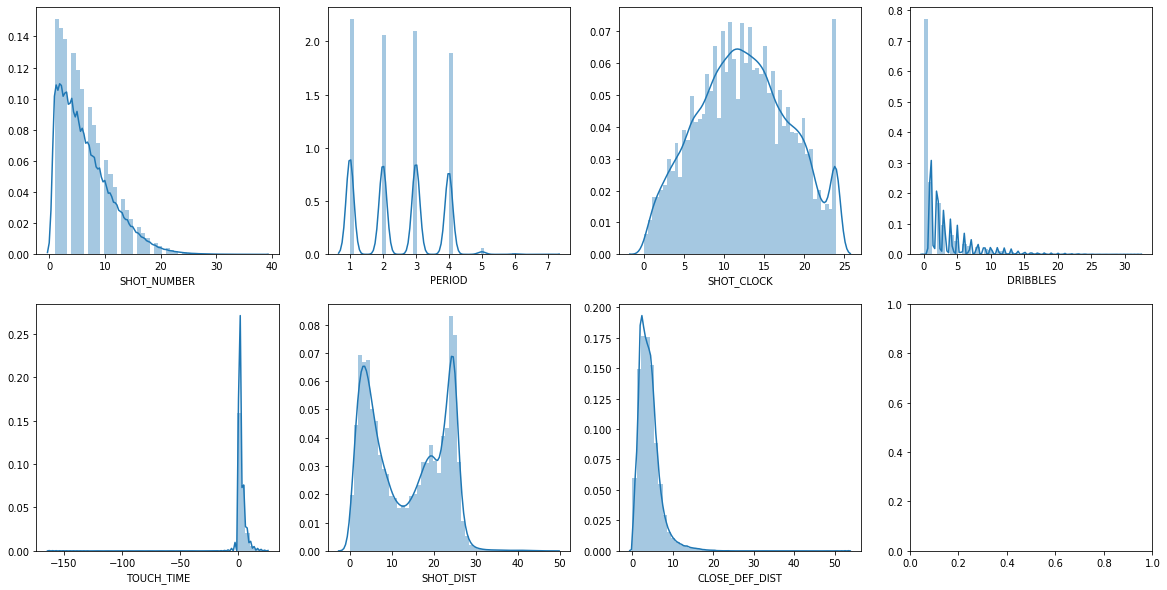

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
for i, column in enumerate(sdta_num.columns):
    sns.distplot(sdta[column],ax=axes[i//4,i%4])

Next we look for correlations or collinearity in the data. 

We will use most of the columns for this correlation analysis, except for arbitrary columns like player_id and game_id. Also, the name columns are dropped because correlation cannot be calculated for categories. We will however keep the binary columns.

Before we do this, we need to encode the SHOT_RESULT column into a boolean/binary column so that a correlation can be computed.

Arbitrarily, we set "made" = 1 and "missed" = 0

In [41]:
sdta["BSKT"] = [1 if s == "made" else 0 for s in sdta.SHOT_RESULT]
sdta.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id,BSKT
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,1.9,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148,1
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,0.8,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148,0
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,2.7,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148,0
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,1.9,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148,0
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148,0


In [42]:
sdta.drop(["GAME_ID","CLOSEST_DEFENDER_PLAYER_ID","player_id"], axis = 1).corr()

,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,FGM,PTS,BSKT
FINAL_MARGIN,1.000000,0.000836,-0.003078,-0.009276,0.011739,0.010788,0.008876,0.024134,0.033064,0.058762,0.064784,0.058762
SHOT_NUMBER,0.000836,1.000000,0.654932,-0.032683,0.141100,0.144071,0.011541,0.003054,-0.037769,-0.008351,-0.009666,-0.008351
PERIOD,-0.003078,0.654932,1.000000,-0.051796,0.055301,0.046089,0.030080,0.048915,-0.010204,-0.014082,-0.008501,-0.014082
SHOT_CLOCK,-0.009276,-0.032683,-0.051796,1.000000,-0.082771,-0.147688,-0.173026,-0.032809,0.026558,0.096855,0.084173,0.096855
DRIBBLES,0.011739,0.141100,0.055301,-0.082771,1.000000,0.914311,-0.082540,-0.169016,-0.153674,-0.034390,-0.055689,-0.034390
TOUCH_TIME,0.010788,0.144071,0.046089,-0.147688,0.914311,1.000000,-0.085165,-0.181007,-0.164737,-0.045299,-0.066736,-0.045299
SHOT_DIST,0.008876,0.011541,0.030080,-0.173026,-0.082540,-0.085165,1.000000,0.740933,0.523192,-0.191704,-0.069147,-0.191704
PTS_TYPE,0.024134,0.003054,0.048915,-0.032809,-0.169016,-0.181007,0.740933,1.000000,0.414198,-0.121293,0.030361,-0.121293
CLOSE_DEF_DIST,0.033064,-0.037769,-0.010204,0.026558,-0.153674,-0.164737,0.523192,0.414198,1.000000,-0.001074,0.063612,-0.001074
FGM,0.058762,-0.008351,-0.014082,0.096855,-0.034390,-0.045299,-0.191704,-0.121293,-0.001074,1.000000,0.970686,1.000000


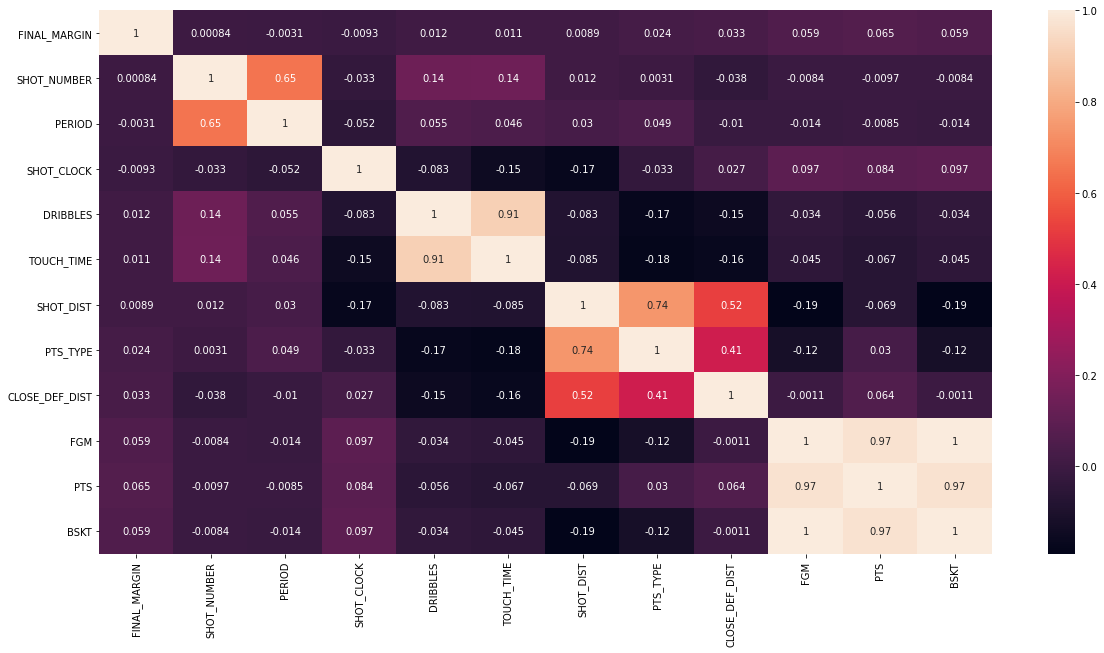

In [43]:
fig, ax =  plt.subplots( figsize=(20,10))
sns.heatmap(sdta.drop(["GAME_ID","CLOSEST_DEFENDER_PLAYER_ID","player_id"], axis = 1).corr(), annot=True, ax = ax)
plt.show()

Not much collinearity in the data other than between DRIBBLES and TOUCH_TIME which is expected, and between PTS_TYPE and SHOT_DIST, which is also expected. 

The high correlation between making the shot (BSKT) and PTS is also trivial since PTS will always be zero for all missed baskets. 

Having explored our game data - we're ready to tackle player data.


### Player Data


In [0]:
url2 = "https://raw.githubusercontent.com/reonho/nba_shotlogs/master/all_seasons.csv"

# static player stats 
pdta = pd.read_csv(url2, index_col = 0)

In [45]:
pdta.head()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,Dennis Rodman,CHI,36.0,198.12,99.790240,Southeastern Oklahoma State,USA,1986,2,27,55,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113,1996-97
1,Dwayne Schintzius,LAC,28.0,215.90,117.933920,Florida,USA,1990,1,24,15,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048,1996-97
2,Earl Cureton,TOR,39.0,205.74,95.254320,Detroit Mercy,USA,1979,3,58,9,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148,1996-97
3,Ed O'Bannon,DAL,24.0,203.20,100.697424,UCLA,USA,1995,1,9,64,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077,1996-97
4,Ed Pinckney,MIA,34.0,205.74,108.862080,Villanova,USA,1985,1,10,27,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040,1996-97


We begin by discarding the data of players not in our shot records. To do this we have to do a join on the players' names, so some processing has to be done at this step.




In [46]:
#shooters format is firstname lastname
shooters = pd.unique(sdta.player_name)

#defenders format is lastname, firstname -> transform this to firstname lastname
defenders = [str(nm).lower().split(", ") for nm in pd.unique(sdta.CLOSEST_DEFENDER)]
defenders = list(map(lambda y: y[1] + " " +  y[0], filter(lambda x: len(x) > 1 , defenders)))
players = pd.DataFrame(np.unique(np.concatenate((np.array(defenders), shooters), axis = 0)))

players

,0
0,a.j. price
1,aaron brooks
2,aaron gordon
3,adreian payne
4,al farouq aminu
...,...
484,xavier henry
485,zach lavine
486,zach randolph
487,zaza pachulia


In [47]:
players.columns = ["name_lower"]
pdta["name_lower"] = [name.lower() for name in pdta.player_name]
pdta1 = players.join(pdta.set_index('name_lower'), on="name_lower")
pdta1

,name_lower,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,a.j. price,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,aaron brooks,Aaron Brooks,HOU,23.0,182.88,73.028312,Oregon,USA,2007,1,26,51.0,5.2,1.1,1.7,-0.5,0.026,0.085,0.224,0.535,0.249,2007-08
1,aaron brooks,Aaron Brooks,HOU,24.0,182.88,73.028312,Oregon,USA,2007,1,26,80.0,11.2,2.0,3.0,4.2,0.021,0.071,0.231,0.521,0.201,2008-09
1,aaron brooks,Aaron Brooks,HOU,25.0,182.88,73.028312,Oregon,USA,2007,1,26,82.0,19.6,2.6,5.3,-0.7,0.021,0.065,0.258,0.549,0.253,2009-10
1,aaron brooks,Aaron Brooks,PHX,26.0,182.88,73.028312,Oregon,USA,2007,1,26,59.0,10.7,1.3,3.9,-6.5,0.017,0.053,0.257,0.489,0.289,2010-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,zaza pachulia,Zaza Pachulia,DAL,32.0,210.82,124.737800,None,Georgia,2003,2,42,76.0,8.6,9.4,1.7,0.9,0.137,0.262,0.164,0.550,0.101,2015-16
487,zaza pachulia,Zaza Pachulia,GSW,33.0,210.82,124.737800,None,Georgia,2003,2,42,70.0,6.1,5.9,1.9,15.8,0.130,0.225,0.151,0.588,0.131,2016-17
487,zaza pachulia,Zaza Pachulia,GSW,34.0,210.82,122.469840,None,Georgia,2003,2,42,69.0,5.4,4.7,1.6,9.4,0.100,0.223,0.165,0.612,0.141,2017-18
487,zaza pachulia,Zaza Pachulia,DET,35.0,210.82,122.469840,None,Georgia,2003,2,42,68.0,3.9,3.9,1.3,-4.6,0.101,0.184,0.147,0.539,0.161,2018-19



Since we only have shot records for the 2014-2015 season, we begin by filtering out the season data to only contain information from or before this time frame. 

To be even more precise and prevent data leakage, we should remove the 2014-15 season's data as well.

First visualise the seasons we have in our data.

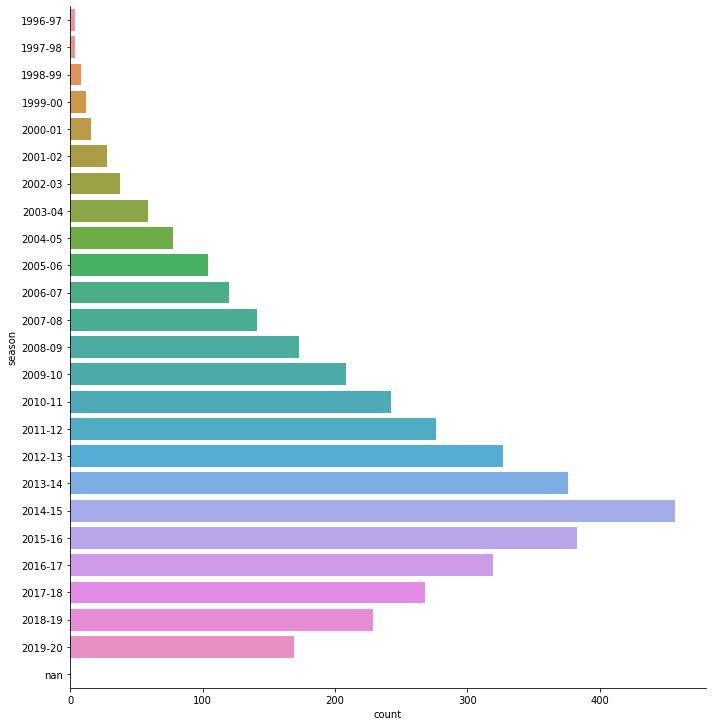

In [48]:
ax = sns.catplot(y= "season", data=pdta1,kind="count", height=10, orient="h", order=pd.unique(sorted([str(szn) for szn in pdta1.season])))

In [0]:
pdta1 = pdta1[~pdta1.season.isin(["2019-20", "2018-19", "2017-18", "2016-17", "2015-16","2014-15"])]

Now conduct some exploratory analysis on the player data. 

We begin by "compressing" the data - summarising the players' past-season performances into averages of their stats per player.

The following will assume the latest values from the 2014-2015 season.
1. Height
2. Weight
3. Age

The rest will be averaged.




In [0]:
pdta1 = pdta1.drop("player_name", axis = 1)

In [51]:
#get height, weight, age from 2014-15 data
pdta2 = players.join(pdta.set_index('name_lower'), on="name_lower")
pdta2 = pdta2[pdta2.season.isin(["2014-15"])]
pdta2 = pdta2[["name_lower", "age", "player_height", "player_weight"]]
pdta2 

,name_lower,age,player_height,player_weight
1,aaron brooks,30.0,182.88,73.028312
2,aaron gordon,19.0,205.74,99.790240
3,adreian payne,24.0,208.28,111.130040
5,al horford,29.0,208.28,113.398000
6,al jefferson,30.0,208.28,131.088088
...,...,...,...,...
484,xavier henry,24.0,198.12,99.790240
485,zach lavine,20.0,195.58,83.007336
486,zach randolph,33.0,205.74,117.933920
487,zaza pachulia,31.0,210.82,122.469840


In [0]:
agg_pdta = pdta1.groupby(by = "name_lower").mean().drop(["age", "player_height", "player_weight"], axis = 1)

In [53]:
agg_pdta.isnull().sum() #total of 31 NAs - we'll drop them

gp            31
pts           31
reb           31
ast           31
net_rating    31
oreb_pct      31
dreb_pct      31
usg_pct       31
ts_pct        31
ast_pct       31
dtype: int64

In [54]:
agg_pdta = agg_pdta.dropna()
agg_pdta = agg_pdta.join(pdta2.set_index('name_lower'), on="name_lower")
agg_pdta

,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,age,player_height,player_weight
name_lower,,,,,,,,,,,,,
aaron brooks,66.166667,10.466667,1.733333,3.216667,-2.783333,0.021667,0.070000,0.226000,0.527833,0.236667,30.0,182.88,73.028312
al horford,60.000000,14.214286,9.114286,2.528571,2.957143,0.088286,0.225857,0.193286,0.574000,0.124143,29.0,208.28,113.398000
al jefferson,70.100000,16.920000,9.120000,1.510000,-3.920000,0.098500,0.247000,0.253100,0.532400,0.086800,30.0,208.28,131.088088
al-farouq aminu,75.750000,6.525000,5.475000,1.125000,-3.275000,0.072250,0.197000,0.155000,0.503750,0.075000,24.0,205.74,97.522280
alan anderson,42.600000,7.820000,2.060000,1.240000,-1.720000,0.033800,0.091200,0.194400,0.522200,0.107200,32.0,198.12,99.790240
...,...,...,...,...,...,...,...,...,...,...,...,...,...
willie green,61.727273,8.190909,1.754545,1.309091,-2.190909,0.018273,0.086364,0.215545,0.504273,0.113364,33.0,190.50,92.986360
wilson chandler,52.428571,12.614286,5.000000,1.714286,-1.242857,0.040571,0.151714,0.205000,0.513286,0.090714,28.0,203.20,102.058200
xavier henry,44.000000,5.875000,1.975000,0.700000,-6.100000,0.031500,0.108750,0.189750,0.473250,0.065250,24.0,198.12,99.790240


Generate summary statistics

In [55]:
agg_pdta.describe()

,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,age,player_height,player_weight
count,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,388.000000,388.000000,388.000000
mean,59.504678,9.104788,3.893391,1.918949,-1.413456,0.059707,0.145791,0.192453,0.525520,0.128643,27.886598,201.101443,101.109992
std,15.884764,5.162661,2.276345,1.745512,6.203353,0.041697,0.053940,0.041641,0.046783,0.087353,4.047205,8.908669,11.987080
min,5.000000,0.700000,0.200000,0.000000,-69.600000,0.000000,0.057833,0.076000,0.224500,0.000000,20.000000,175.260000,73.028312
25%,51.800000,5.100000,2.290909,0.700000,-4.290909,0.024750,0.098933,0.164000,0.503750,0.065250,25.000000,194.945000,91.171992
50%,63.000000,8.100000,3.333333,1.325000,-1.525000,0.046500,0.135800,0.192000,0.527538,0.098250,27.000000,203.200000,102.058200
75%,71.428571,11.800000,5.000000,2.600000,1.850000,0.093000,0.185333,0.219000,0.550667,0.178333,30.000000,208.280000,111.130040
max,82.000000,27.509091,12.920000,9.922222,27.100000,0.311500,0.298833,0.317182,0.677000,0.444333,39.000000,218.440000,133.809640


Visualise the spread of data for all players.


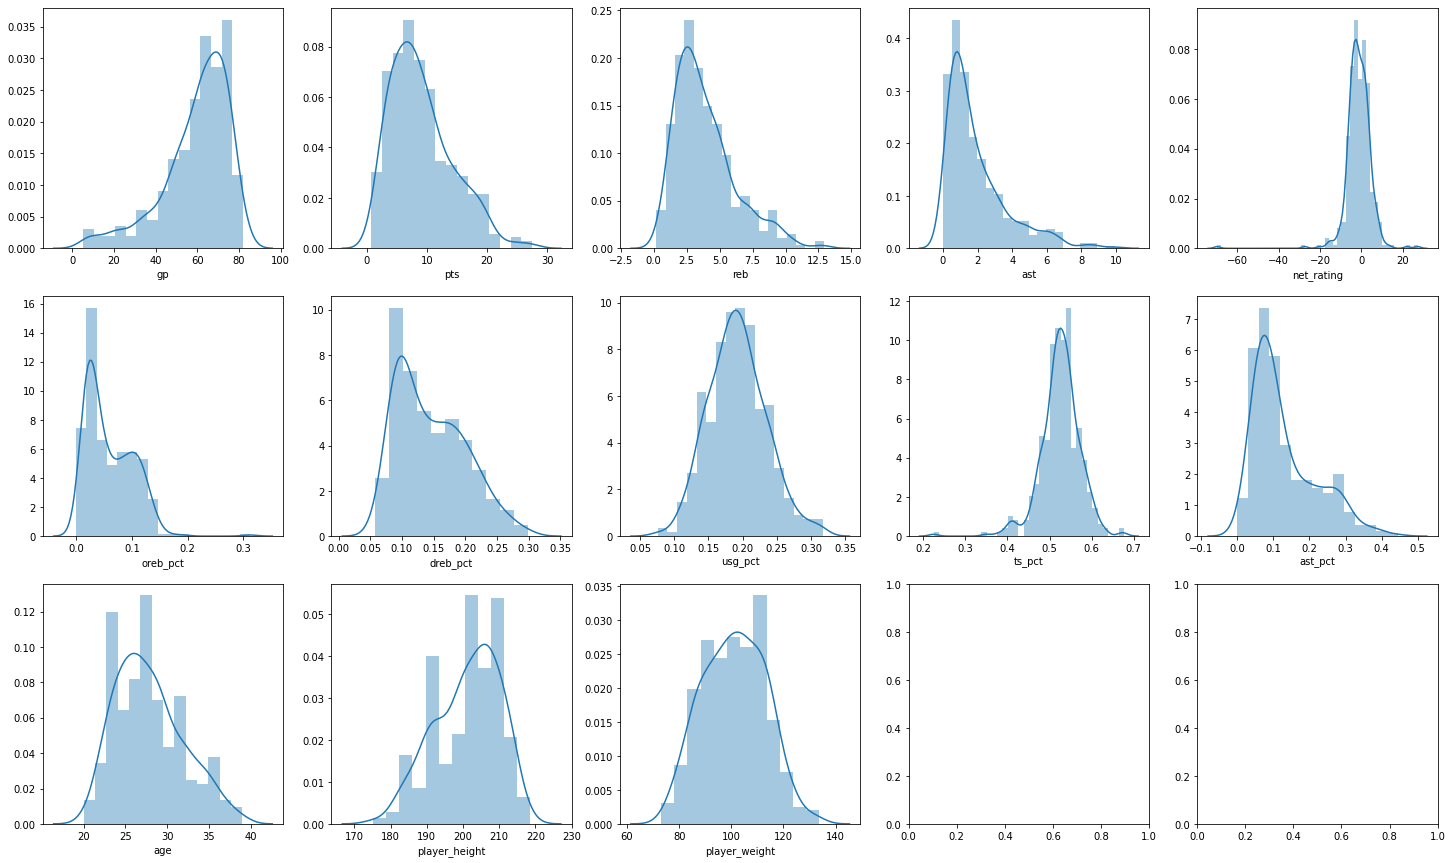

In [56]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25,15))
for i, column in enumerate(agg_pdta.columns):
    sns.distplot(agg_pdta[column],ax=axes[i//5,i%5])

It can be observed that most of the player stats here are normally distributed (although some are heavily skewed)

## Data Preparation
###  Joining Player and Shot Log Data

So begins the task of joining all the player data onto the shot log data. We want to join both shooter and defender data into the shots dataframe. Basically, we want to augment our shots data with nformation on the shooter-defender match up.

In [57]:
#joining shooter data
s_agg = agg_pdta.copy()
s_agg.columns= ["shooter_" + col for col in agg_pdta.columns]
sdta1 = sdta.join(s_agg, on="player_name")
sdta1.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id,BSKT,shooter_gp,shooter_pts,shooter_reb,shooter_ast,shooter_net_rating,shooter_oreb_pct,shooter_dreb_pct,shooter_usg_pct,shooter_ts_pct,shooter_ast_pct,shooter_age,shooter_player_height,shooter_player_weight
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,1.9,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148,1,75.0,8.25,1.55,3.05,-6.6,0.013,0.08,0.211,0.519,0.2635,29.0,185.42,78.471416
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,0.8,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148,0,75.0,8.25,1.55,3.05,-6.6,0.013,0.08,0.211,0.519,0.2635,29.0,185.42,78.471416
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,2.7,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148,0,75.0,8.25,1.55,3.05,-6.6,0.013,0.08,0.211,0.519,0.2635,29.0,185.42,78.471416
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,1.9,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148,0,75.0,8.25,1.55,3.05,-6.6,0.013,0.08,0.211,0.519,0.2635,29.0,185.42,78.471416
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148,0,75.0,8.25,1.55,3.05,-6.6,0.013,0.08,0.211,0.519,0.2635,29.0,185.42,78.471416


In [0]:
defender = [str(nm).lower().split(", ") for nm in sdta.CLOSEST_DEFENDER]
sdta1["defender"] = list(map(lambda y: y[1] + " " +  y[0] if len(y) > 1 else y[0], defender))

In [0]:
#joining defender data
d_agg = agg_pdta.copy()
d_agg.columns= ["defender_" + col for col in agg_pdta.columns]
sdta2 = sdta1.join(d_agg, on="defender")

In [60]:
#percent of data that is incomplete
max(sdta2.isnull().sum())/sdta2.shape[0]

0.10807455356097104

We have about 10% of the shot data being incomplete - these will be dropped. 

In [0]:
sdta2 = sdta2.dropna()

Done with the data preparation! This is how our final data looks like:

In [62]:
sdta2.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id,BSKT,shooter_gp,shooter_pts,shooter_reb,shooter_ast,shooter_net_rating,shooter_oreb_pct,shooter_dreb_pct,shooter_usg_pct,shooter_ts_pct,shooter_ast_pct,shooter_age,shooter_player_height,shooter_player_weight,defender,defender_gp,defender_pts,defender_reb,defender_ast,defender_net_rating,defender_oreb_pct,defender_dreb_pct,defender_usg_pct,defender_ts_pct,defender_ast_pct,defender_age,defender_player_height,defender_player_weight
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,1.9,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148,1,75.0,8.25,1.55,3.05,-6.6,0.013,0.08,0.211,0.519,0.2635,29.0,185.42,78.471416,alan anderson,42.600000,7.820000,2.060000,1.240000,-1.720000,0.033800,0.091200,0.194400,0.522200,0.107200,32.0,198.12,99.790240
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148,0,75.0,8.25,1.55,3.05,-6.6,0.013,0.08,0.211,0.519,0.2635,29.0,185.42,78.471416,thaddeus young,73.714286,13.642857,5.485714,1.342857,1.114286,0.077000,0.135143,0.210143,0.542714,0.073857,27.0,203.20,100.243832
5,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,6,2,8:15,9.1,2,4.4,18.4,2,missed,"Williams, Deron",101114,2.6,0,0,brian roberts,203148,0,75.0,8.25,1.55,3.05,-6.6,0.013,0.08,0.211,0.519,0.2635,29.0,185.42,78.471416,deron williams,72.000000,17.577778,3.166667,8.700000,1.588889,0.015000,0.090889,0.239778,0.556444,0.397000,31.0,190.50,90.718400
6,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,7,4,10:15,14.5,11,9.0,20.7,2,missed,"Jack, Jarrett",101127,6.1,0,0,brian roberts,203148,0,75.0,8.25,1.55,3.05,-6.6,0.013,0.08,0.211,0.519,0.2635,29.0,185.42,78.471416,jarrett jack,76.777778,11.111111,2.833333,4.433333,-4.855556,0.013667,0.102444,0.197333,0.543667,0.260000,31.0,190.50,90.718400
7,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,8,4,8:00,3.4,3,2.5,3.5,2,made,"Plumlee, Mason",203486,2.1,1,2,brian roberts,203148,1,75.0,8.25,1.55,3.05,-6.6,0.013,0.08,0.211,0.519,0.2635,29.0,185.42,78.471416,mason plumlee,70.000000,7.400000,4.400000,0.900000,-1.300000,0.094000,0.199000,0.172000,0.670000,0.082000,25.0,210.82,106.594120


## Econometric Analysis
### Logistic Regression

Our target variable, or dependent variable, is the BSKT feature that was created from SHOT_RESULT earlier. This is a binary feature, which makes the logit model a good choice for fitting the data. 

The logistic regression function takes the following form.

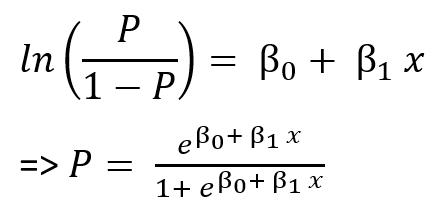

Where P is the probability of making the basket, x represents all our explanatory variables, and beta represents the coefficients for our features





The logistic regression finds coeffecients for each of the explanatory variables via a process known as maximum likelihood estimation. For each observation, we are able to compute a probability above given a set of beta values. 

The maximum likelihood estimation then looks for the set of beta values that maximises the product of probabilities for all observations.

### Implementation

First we exercise some subjective judgement and/or domain knowledge, and purge our data of columns that we will not be using for our regression analysis. 






In [63]:
sdta2.columns

Index(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER',
       'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSEST_DEFENDER',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS',
       'player_name', 'player_id', 'BSKT', 'shooter_gp', 'shooter_pts',
       'shooter_reb', 'shooter_ast', 'shooter_net_rating', 'shooter_oreb_pct',
       'shooter_dreb_pct', 'shooter_usg_pct', 'shooter_ts_pct',
       'shooter_ast_pct', 'shooter_age', 'shooter_player_height',
       'shooter_player_weight', 'defender', 'defender_gp', 'defender_pts',
       'defender_reb', 'defender_ast', 'defender_net_rating',
       'defender_oreb_pct', 'defender_dreb_pct', 'defender_usg_pct',
       'defender_ts_pct', 'defender_ast_pct', 'defender_age',
       'defender_player_height', 'defender_player_weight'],
      dtype='object')

In [0]:
remove_columns = ["GAME_ID", "MATCHUP", "W", "player_id", "CLOSEST_DEFENDER_PLAYER_ID" ,"CLOSEST_DEFENDER", "player_name", "defender", "SHOT_RESULT", "PTS", "FGM"]
data = sdta2.drop(remove_columns, axis = 1)

Label encode the following categorical columns.

1. LOCATION -> into whether the game is played at home
2. PTS_TYPE -> into whether the shot was a 2 pointer

In [0]:
data["HOME"] = [ 0 if loc == "A" else 1 for loc in data.LOCATION]
data["2PT"] = [1 if pt == 2 else 0 for pt in data.PTS_TYPE]
data = data.drop(["LOCATION", "PTS_TYPE"], axis = 1)

Transform the time values in the GAME_CLOCK column into number of minutes in a decimal format.

In [0]:
gameclock = [float(t.split(":")[0]) + (float(t.split(":")[1])/60) for t in data.GAME_CLOCK]
data["GAME_CLOCK"] = gameclock


Logistic regression has the added benefit of not requiring any standardization of variables so we are able to skip that step.

In [127]:
data

,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST,BSKT,shooter_gp,shooter_pts,shooter_reb,shooter_ast,shooter_net_rating,shooter_oreb_pct,shooter_dreb_pct,shooter_usg_pct,shooter_ts_pct,shooter_ast_pct,shooter_age,shooter_player_height,shooter_player_weight,defender_gp,defender_pts,defender_reb,defender_ast,defender_net_rating,defender_oreb_pct,defender_dreb_pct,defender_usg_pct,defender_ts_pct,defender_ast_pct,defender_age,defender_player_height,defender_player_weight,HOME,2PT
0,24,1,1,1.150000,10.8,2,1.9,7.7,1.3,1,75.000000,8.250000,1.550000,3.050000,-6.600000,0.013000,0.080000,0.211000,0.519000,0.2635,29.0,185.42,78.471416,42.600000,7.820000,2.060000,1.240000,-1.720000,0.033800,0.091200,0.194400,0.522200,0.107200,32.0,198.12,99.790240,0,1
4,24,5,2,10.566667,10.9,2,2.7,3.7,1.1,0,75.000000,8.250000,1.550000,3.050000,-6.600000,0.013000,0.080000,0.211000,0.519000,0.2635,29.0,185.42,78.471416,73.714286,13.642857,5.485714,1.342857,1.114286,0.077000,0.135143,0.210143,0.542714,0.073857,27.0,203.20,100.243832,0,1
5,24,6,2,8.250000,9.1,2,4.4,18.4,2.6,0,75.000000,8.250000,1.550000,3.050000,-6.600000,0.013000,0.080000,0.211000,0.519000,0.2635,29.0,185.42,78.471416,72.000000,17.577778,3.166667,8.700000,1.588889,0.015000,0.090889,0.239778,0.556444,0.397000,31.0,190.50,90.718400,0,1
6,24,7,4,10.250000,14.5,11,9.0,20.7,6.1,0,75.000000,8.250000,1.550000,3.050000,-6.600000,0.013000,0.080000,0.211000,0.519000,0.2635,29.0,185.42,78.471416,76.777778,11.111111,2.833333,4.433333,-4.855556,0.013667,0.102444,0.197333,0.543667,0.260000,31.0,190.50,90.718400,0,1
7,24,8,4,8.000000,3.4,3,2.5,3.5,2.1,1,75.000000,8.250000,1.550000,3.050000,-6.600000,0.013000,0.080000,0.211000,0.519000,0.2635,29.0,185.42,78.471416,70.000000,7.400000,4.400000,0.900000,-1.300000,0.094000,0.199000,0.172000,0.670000,0.082000,25.0,210.82,106.594120,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128061,-16,2,2,10.166667,19.0,0,-0.2,7.4,2.7,0,76.777778,11.111111,2.833333,4.433333,-4.855556,0.013667,0.102444,0.197333,0.543667,0.2600,31.0,190.50,90.718400,51.250000,8.350000,2.075000,1.325000,-3.550000,0.028750,0.082500,0.214750,0.471500,0.109500,24.0,187.96,81.646560,0,1
128063,-16,4,2,5.083333,15.3,2,1.6,8.9,5.7,1,76.777778,11.111111,2.833333,4.433333,-4.855556,0.013667,0.102444,0.197333,0.543667,0.2600,31.0,190.50,90.718400,59.500000,9.650000,7.000000,1.200000,0.400000,0.125500,0.215500,0.193000,0.515500,0.079500,23.0,205.74,117.933920,0,1
128065,-16,6,4,11.466667,19.8,4,5.2,0.6,0.6,1,76.777778,11.111111,2.833333,4.433333,-4.855556,0.013667,0.102444,0.197333,0.543667,0.2600,31.0,190.50,90.718400,76.500000,10.975000,5.250000,3.075000,-1.975000,0.023500,0.184000,0.204500,0.484500,0.166750,26.0,200.66,99.790240,0,1
128066,-16,7,4,11.166667,23.0,2,4.2,16.9,4.2,1,76.777778,11.111111,2.833333,4.433333,-4.855556,0.013667,0.102444,0.197333,0.543667,0.2600,31.0,190.50,90.718400,68.200000,13.700000,3.080000,1.540000,-4.320000,0.040400,0.095200,0.230600,0.536400,0.098200,28.0,193.04,92.986360,0,1


Check for matrix singularity, or collinearity

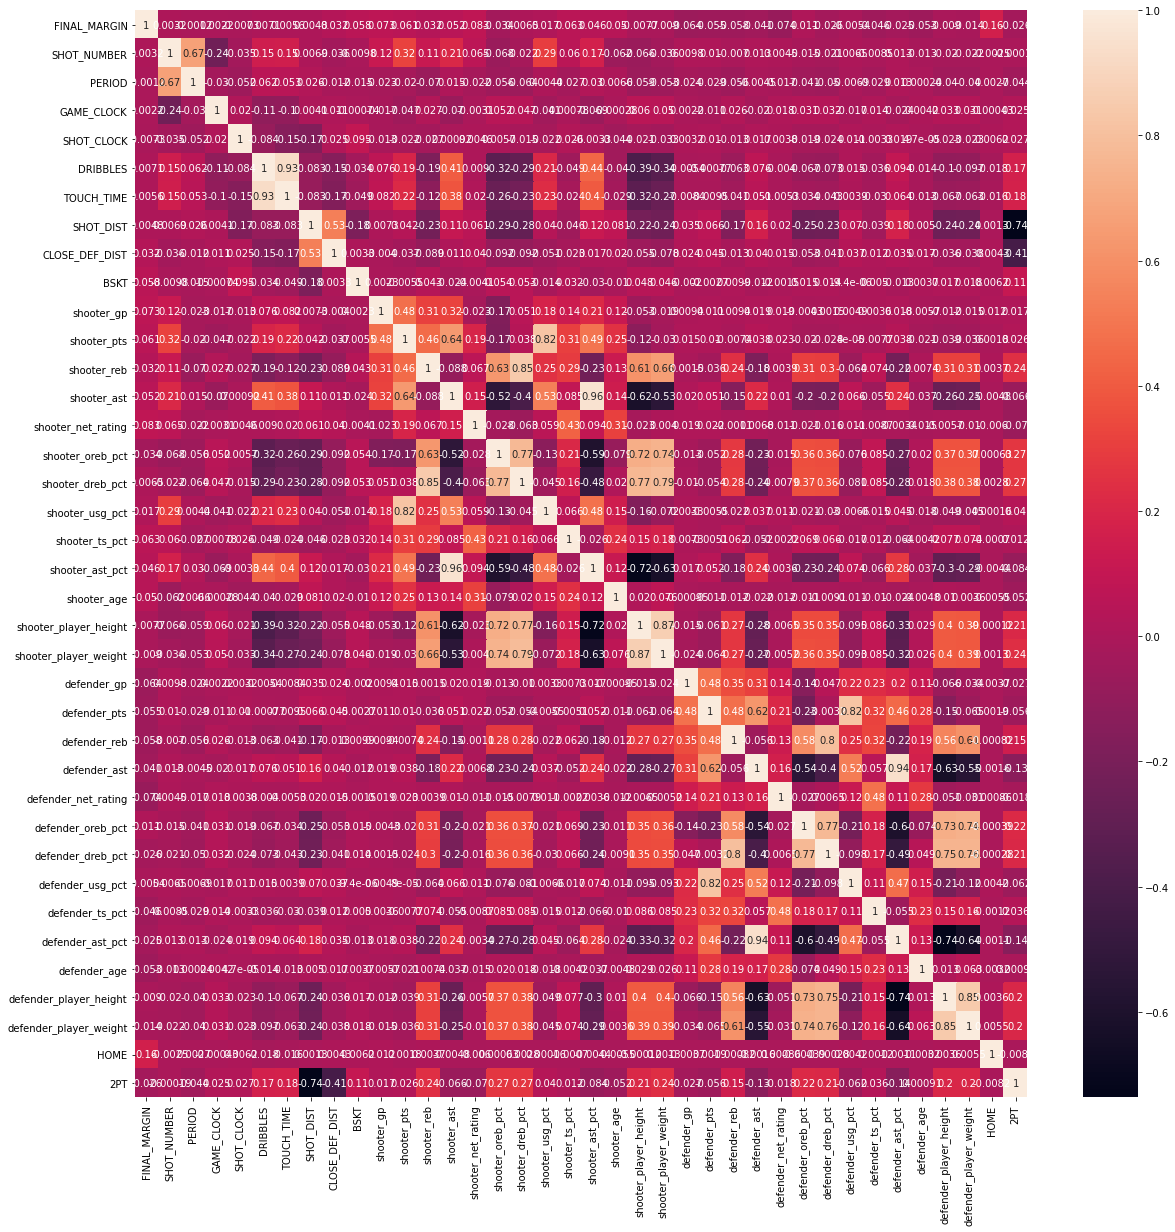

In [149]:
fig, ax =  plt.subplots( figsize=(20,20))
sns.heatmap(data.corr(), annot=True, ax = ax)
plt.show()

There are no perfectly linearly related columns, proceed to fit our data to a logistic model.

### Fitting our Data

We start by splitting our data into a 70% training and 30% testing set.

In [0]:
from sklearn import model_selection
tts = model_selection.train_test_split
train_set, test_set = tts(data, test_size = 0.3)

In [0]:
Xtrain = train_set.drop("BSKT", axis = 1)
Xtest = test_set.drop("BSKT", axis = 1)
ytrain = train_set["BSKT"]
ytest = test_set["BSKT"]

We can then fit the data to the logit model using MLE.

In [132]:
from statsmodels.discrete.discrete_model import Logit
log_model = Logit(ytrain.astype(float), Xtrain.astype(float)).fit()

Optimization terminated successfully.
         Current function value: 0.659651
         Iterations 5


In [138]:
print(log_model.summary())

                           Logit Regression Results                           
Dep. Variable:                   BSKT   No. Observations:                70148
Model:                          Logit   Df Residuals:                    70111
Method:                           MLE   Df Model:                           36
Date:                Sun, 24 May 2020   Pseudo R-squ.:                 0.04275
Time:                        07:35:33   Log-Likelihood:                -46273.
converged:                       True   LL-Null:                       -48340.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
FINAL_MARGIN               0.0094      0.001     15.250      0.000       0.008       0.011
SHOT_NUMBER                0.0025      0.003      0.914      0.361      -0.003       0.008
PERI

### Interpreting Coefficients

The following columns were found to be significant: ....


### Accuracy
We test the model using the test set that we set aside previously.




In [145]:
ypred = log_model.predict(Xtest.astype(float))
ypred

106904    0.520931
64821     0.633780
60188     0.606817
103025    0.334976
105458    0.528245
            ...   
58099     0.480155
108199    0.370757
30853     0.513758
101748    0.581656
17919     0.474034
Length: 30064, dtype: float64

Visualise the predictions with a confusion matrix.

In [154]:
confmat = pd.DataFrame(metrics.confusion_matrix(ytest, ypred >0.5))
confmat.columns = ["Actual Missed","Actual Made"]
confmat.index = ["Predicted Missed","Predicited Made"]
confmat

,Actual Missed,Actual Made
Predicted Missed,11837,4307
Predicited Made,7437,6483


In [148]:
from sklearn import metrics
print(metrics.classification_report(ytest, ypred > 0.5))

              precision    recall  f1-score   support

           0       0.61      0.73      0.67     16144
           1       0.60      0.47      0.52     13920

    accuracy                           0.61     30064
   macro avg       0.61      0.60      0.60     30064
weighted avg       0.61      0.61      0.60     30064



We can now analyse our model's accuracy.

The recall on 0 (missed basket) is 0.73 - which means the logistic model is able to identify 73% of all shots that actually miss. 

The recall on 1 (made basket) is 0.47 - which means the logistic model is able to identify only 47% of all shots that actually score. 

The precision for 1 and 0 is 0.6 and 0.61 respectively. This means that about 60% of the time the model says the shot will be missed, the shot will be missed. 

We can think of it as the model being correct 60% of the time. This appears useful for teams having to play a safe game. Suppose we follow a naive strategy of shooting only when the model predicts the shot making it, then we are statistically assured to only miss 40% of our shots. 

Pretty good, compared to a less than 50% chance of making 2 pointers and 33% chance of making 3 pointers without our model.






In [0]:
roc_curve = metrics.roc_curve
auc = metrics.auc

def get_roc(y_test, y_pred, name):
  fpr = roc_curve(y_test,y_pred)[0]
  tpr = roc_curve(y_test,y_pred)[1]
  thresholds = roc_curve(y_test,y_pred)[2]
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic for ' + name)
  plt.plot(fpr,tpr,label='ROC curve (AUC = %0.2f)' % (auc(fpr, tpr)))
  plt.legend(loc="lower right")

  #find- best threshold
  optimal_idx = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal_idx]
  print("Optimal Threshold: " + str(optimal_threshold))

  plt.show()

  return auc(fpr, tpr)

Optimal Threshold: 0.4995344763785295


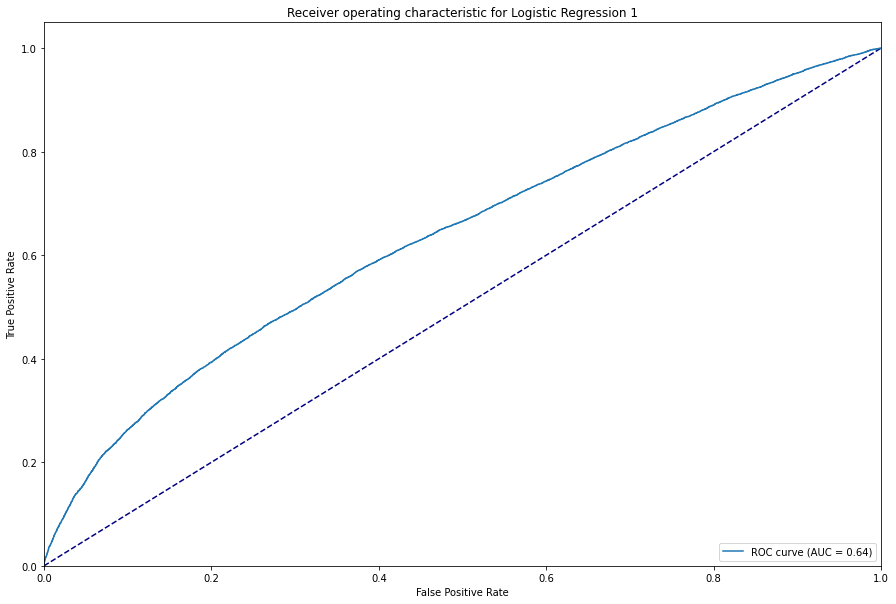

0.635156588191905

In [167]:
fig, ax =  plt.subplots( figsize=(15,10))
get_roc(ytest, ypred, "Logistic Regression 1")

This is pretty promising. The AUC is 0.635 and the model does perform better than a random model (diagonal 45 degree line, AUC = 0.5) at predicting if a shot will make the basket.

### Revisiting the Model - considering interactions, polynomial terms 
We expect some columns to interact, such as shooter height interacting with defender height i.e. the ratio of their heights affect the shot accuracy.